## Imports 

### Importing Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from textblob import TextBlob
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Install necessary packages
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install('matplotlib')
install('seaborn')
install('textblob')
install('wordcloud')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rolosworld/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/rolosworld/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to
[nltk_data]     /Users/rolosworld/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Data Cleaning
# Cornell Movie Dialogs Corpus Data Loading

This section covers loading and inspecting the **Cornell Movie Dialogs Corpus** using Python's `pandas` and `os` libraries. We'll load metadata about movies, characters, and conversational lines, and then preview the data.



In [8]:
import os
import pandas as pd

dataset_dir = "/kaggle/input/cornell-moviedialog-corpus"
file_path = os.path.join(dataset_dir, 'movie_titles_metadata.txt')

# Read the file using pandas, specifying the correct separator
movie_titles = pd.read_csv(file_path, 
                           sep=' \+\+\+\$\+\+\+ ',  # Use regex-escaped separator
                           engine='python',
                           names=['movieID', 'title', 'year', 'rating', 'votes', 'genres'],
                           encoding='latin-1')

# Display the first few rows
print(movie_titles.head())

# Display info about the dataframe
print(movie_titles.info())

# Load character metadata
characters = pd.read_csv(os.path.join(dataset_dir, 'movie_characters_metadata.txt'), 
                         sep=' \+\+\+\$\+\+\+ ',
                         engine='python',
                         names=['characterID', 'name', 'movieID', 'movie_title', 'gender', 'position'],
                         encoding='latin-1')

# Load movie lines
with open(os.path.join(dataset_dir, 'movie_lines.txt'), 'r', encoding='iso-8859-1') as f:
    lines = [line.strip().split(' +++$+++ ') for line in f]
movie_lines = pd.DataFrame(lines, columns=['lineID', 'characterID', 'movieID', 'character', 'text'])

# Load conversations
with open(os.path.join(dataset_dir, 'movie_conversations.txt'), 'r', encoding='iso-8859-1') as f:
    convos = [line.strip().split(' +++$+++ ') for line in f]
conversations = pd.DataFrame(convos, columns=['char1ID', 'char2ID', 'movieID', 'utterances'])

# Print the first few rows of each dataframe to verify
print("\nCharacters:")
print(characters.head())
print("\nMovie Lines:")
print(movie_lines.head())
print("\nConversations:")
print(conversations.head())

  movieID                       title  year  rating   votes  \
0      m0  10 things i hate about you  1999     6.9   62847   
1      m1  1492: conquest of paradise  1992     6.2   10421   
2      m2                  15 minutes  2001     6.1   25854   
3      m3       2001: a space odyssey  1968     8.4  163227   
4      m4                     48 hrs.  1982     6.9   22289   

                                              genres  
0                              ['comedy', 'romance']  
1     ['adventure', 'biography', 'drama', 'history']  
2           ['action', 'crime', 'drama', 'thriller']  
3                 ['adventure', 'mystery', 'sci-fi']  
4  ['action', 'comedy', 'crime', 'drama', 'thrill...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieID  617 non-null    object 
 1   title    617 non-null    object 
 2   year     617 non-null    objec

### Cleaning year column: Following code identifies entries in the `movie_titles` dataframe where the 'year' column contains non-standard values (i.e., values that cannot be converted to a numeric type). This is achieved by attempting to coerce the 'year' column to numeric values using `pd.to_numeric()`. If coercion fails (`NaN` values), those entries are considered non-standard.

In [10]:
# Find non-standard year entries
non_standard_years = movie_titles[pd.to_numeric(movie_titles['year'], errors='coerce').isna()]
print("Non-standard year entries:")
print(non_standard_years[['movieID', 'title', 'year']])

Non-standard year entries:
    movieID                     title    year
33      m33                black rain  1989/I
106    m106            jacob's ladder  1990/I
156    m156                   panther  1995/I
268    m268                   beloved  1998/I
307    m307                     crash  2004/I
308    m308                crazy love  2007/I
386    m386                      hero  1992/I
389    m389                   hostage  2005/I
398    m398                  insomnia  2002/I
429    m429  the man in the iron mask  1998/I
493    m493          romeo and juliet  1968/I
507    m507                    scream  1996/I
521    m521                   soldier  1998/I
559    m559                 the beach  2000/I
565    m565             the messenger  2009/I
605    m605         who's your daddy?  2003/I


 ## Clean and Convert Year Column in the Movie Titles Data

The following code cleans and converts the 'year' column in the `movie_titles` dataframe. It extracts the first 4-digit year from the 'year' entries, handling cases where the year might be embedded within a string or where there are non-standard formats.


In [11]:
import re

def clean_year(year_str):
    # Extract the first 4-digit number from the string
    match = re.search(r'\d{4}', str(year_str))
    if match:
        return int(match.group())
    else:
        return None  # or you could return a default value like 0

# Apply the cleaning function
movie_titles['year_clean'] = movie_titles['year'].apply(clean_year)

# Convert to numeric, replacing any remaining non-numeric values with NaN
movie_titles['year_numeric'] = pd.to_numeric(movie_titles['year_clean'], errors='coerce')

# Check the results
print("\nCleaned year column:")
print(movie_titles[['movieID', 'title', 'year', 'year_clean', 'year_numeric']].head(10))

# Check if there are any remaining NaN values
nan_years = movie_titles[movie_titles['year_numeric'].isna()]
print("\nEntries with NaN years after cleaning:")
print(nan_years[['movieID', 'title', 'year', 'year_clean', 'year_numeric']])


Cleaned year column:
  movieID                                          title  year  year_clean  \
0      m0                     10 things i hate about you  1999        1999   
1      m1                     1492: conquest of paradise  1992        1992   
2      m2                                     15 minutes  2001        2001   
3      m3                          2001: a space odyssey  1968        1968   
4      m4                                        48 hrs.  1982        1982   
5      m5                              the fifth element  1997        1997   
6      m6                                            8mm  1999        1999   
7      m7  a nightmare on elm street 4: the dream master  1988        1988   
8      m8     a nightmare on elm street: the dream child  1989        1989   
9      m9                           the atomic submarine  1959        1959   

   year_numeric  
0          1999  
1          1992  
2          2001  
3          1968  
4          1982  
5          

### Checking Genre Column: ## Display Sample of the 'Genres' Column and Check its Data Type

This code snippet outputs a sample of the `genres` column from the `movie_titles` dataframe, along with the data type of the column. This is useful for verifying the content and structure of the `genres` data.

In [15]:
print("Sample of genres:")
print(movie_titles['genres'].head(10))
print("\nData type of genres column:", movie_titles['genres'].dtype)

Sample of genres:
0                                 [comedy, romance]
1            [adventure, biography, drama, history]
2                  [action, crime, drama, thriller]
3                      [adventure, mystery, sci-fi]
4          [action, comedy, crime, drama, thriller]
5    [action, adventure, romance, sci-fi, thriller]
6                        [crime, mystery, thriller]
7                       [fantasy, horror, thriller]
8                       [fantasy, horror, thriller]
9                                [sci-fi, thriller]
Name: genres, dtype: object

Data type of genres column: object


### Checking utterances column

In [17]:
print("Sample of utterances:")
print(conversations['utterances'].head())
print("\nData type of utterances column:", conversations['utterances'].dtype)

Sample of utterances:
0    [L194, L195, L196, L197]
1                [L198, L199]
2    [L200, L201, L202, L203]
3          [L204, L205, L206]
4                [L207, L208]
Name: utterances, dtype: object

Data type of utterances column: object


## Analysis

In [21]:
# Convert 'position' to numeric in characters, replacing '?' with NaN
characters['position'] = pd.to_numeric(characters['position'], errors='coerce')

# Merge movie lines with character information
lines_with_char_info = pd.merge(movie_lines, characters[['characterID', 'gender', 'position']], on='characterID')

# Merge movie lines with movie information
lines_with_movie_info = pd.merge(lines_with_char_info, movie_titles[['movieID', 'title', 'year_numeric', 'rating', 'genres']], on='movieID')

# Perform some basic analysis
lines_per_movie = lines_with_movie_info.groupby('movieID').size().sort_values(ascending=False)
lines_per_character = lines_with_movie_info.groupby('characterID').size().sort_values(ascending=False)
avg_line_length = lines_with_movie_info.groupby('movieID')['text'].apply(lambda x: x.str.len().mean())

print("\nTop 5 movies by number of lines:")
print(lines_per_movie.head())
print("\nTop 5 characters by number of lines:")
print(lines_per_character.head())
print("\nTop 5 movies by average line length:")
print(avg_line_length.sort_values(ascending=False).head())

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):
        return []
    tokens = word_tokenize(str(text).lower())
    return [w for w in tokens if w.isalnum() and w not in stop_words]

# Perform some basic analysis
lines_per_movie = lines_with_movie_info.groupby('movieID').size().sort_values(ascending=False)
lines_per_character = lines_with_movie_info.groupby('characterID').size().sort_values(ascending=False)
avg_line_length = lines_with_movie_info.groupby('movieID')['text'].apply(lambda x: x.str.len().mean())

print("\nTop 5 movies by number of lines:")
print(lines_per_movie.head())
print("\nTop 5 characters by number of lines:")
print(lines_per_character.head())
print("\nTop 5 movies by average line length:")
print(avg_line_length.sort_values(ascending=False).head())

lines_with_movie_info['processed_text'] = lines_with_movie_info['text'].apply(preprocess_text)

# Generate word frequency distribution
all_words = [word for words in lines_with_movie_info['processed_text'] for word in words]
word_freq = Counter(all_words)

print("\nTop 20 most common words:")
print(word_freq.most_common(20))

# Additional analysis: Movies by decade
lines_with_movie_info['decade'] = (lines_with_movie_info['year_numeric'] // 10) * 10
movies_by_decade = lines_with_movie_info.groupby('decade')['movieID'].nunique().sort_index()

print("\nNumber of movies by decade:")
print(movies_by_decade)

# Genre analysis
genre_counts = Counter([genre for genres in movie_titles['genres'] for genre in genres])

print("\nTop 10 most common genres:")
print(genre_counts.most_common(10))

# Average rating by genre
genre_ratings = lines_with_movie_info.explode('genres').groupby('genres')['rating'].mean().sort_values(ascending=False)

print("\nAverage rating by genre:")
print(genre_ratings)


Top 5 movies by number of lines:
movieID
m289    1530
m295    1398
m299    1286
m105    1214
m238    1187
dtype: int64

Top 5 characters by number of lines:
characterID
u4525    537
u1169    489
u1475    472
u3681    467
u4331    465
dtype: int64

Top 5 movies by average line length:
movieID
m521    256.384615
m56     143.523179
m382    118.523148
m104    117.064865
m406    112.076923
Name: text, dtype: float64

Top 5 movies by number of lines:
movieID
m289    1530
m295    1398
m299    1286
m105    1214
m238    1187
dtype: int64

Top 5 characters by number of lines:
characterID
u4525    537
u1169    489
u1475    472
u3681    467
u4331    465
dtype: int64

Top 5 movies by average line length:
movieID
m521    256.384615
m56     143.523179
m382    118.523148
m104    117.064865
m406    112.076923
Name: text, dtype: float64

Top 20 most common words:
[('know', 21649), ('like', 15000), ('get', 14149), ('got', 13297), ('want', 11055), ('think', 10779), ('one', 10575), ('right', 10019), ('go'

"Action" and "Horror" genres have lower average ratings (6.51 and 6.17, respectively). This suggests that more serious, dramatic genres (e.g., film-noir, war) tend to be rated higher by viewers, while action-oriented genres receive lower ratings on average. This data provides insights into the distribution of dialogue, characters, genres, and ratings within the movie dialogue dataset.

In [24]:
print("Number of null values in 'text' column:", lines_with_movie_info['text'].isnull().sum())

Number of null values in 'text' column: 267


This code helps explore the relationships between various movie features (like year, rating, votes, and line length) and provides a visual and statistical overview of the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movieID          617 non-null    object 
 1   title            617 non-null    object 
 2   year             617 non-null    object 
 3   rating           617 non-null    float64
 4   votes            617 non-null    int64  
 5   genres           617 non-null    object 
 6   year_clean       617 non-null    int64  
 7   year_numeric     617 non-null    int64  
 8   line_count       0 non-null      float64
 9   avg_line_length  617 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 48.3+ KB
None

Columns with infinite values:
movieID            0
title              0
year               0
rating             0
votes              0
genres             0
year_clean         0
year_numeric       0
line_count         0
avg_line_length    0
dtype: int64

Shape of movie_featu

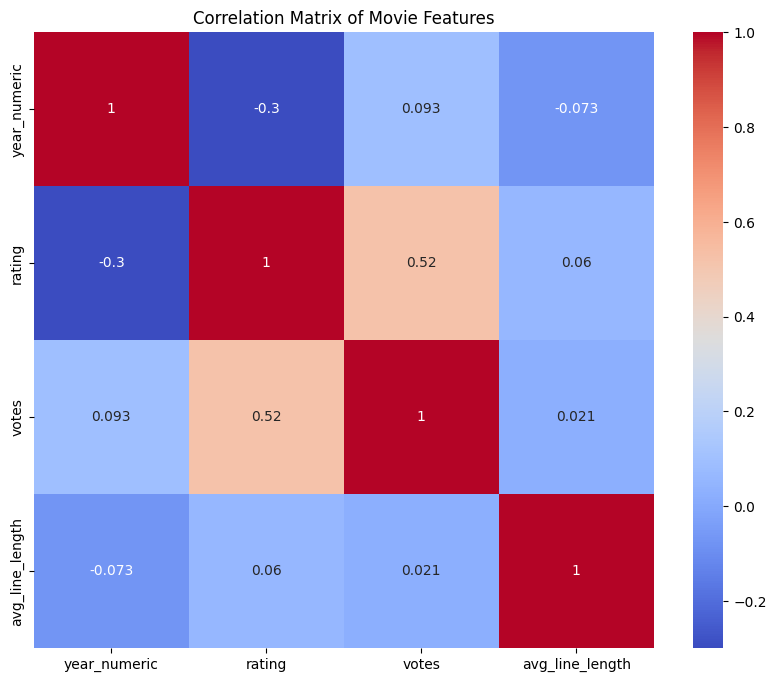


Correlation matrix:
                 year_numeric    rating     votes  avg_line_length
year_numeric         1.000000 -0.299029  0.093051        -0.072956
rating              -0.299029  1.000000  0.518592         0.059646
votes                0.093051  0.518592  1.000000         0.020686
avg_line_length     -0.072956  0.059646  0.020686         1.000000

Correlation between year and rating: -0.30
P-value: 0.0000

Correlation between votes and rating: 0.52
P-value: 0.0000

Correlation between average line length and rating: 0.06
P-value: 0.1389

Basic statistics of movie features:
       year_numeric      rating          votes  avg_line_length
count    617.000000  617.000000     617.000000       617.000000
mean    1988.575365    6.863857   49820.962723        56.306179
std       16.589229    1.215233   61880.609145        15.227518
min     1927.000000    2.500000       9.000000        26.332602
25%     1984.000000    6.200000    9919.000000        47.695067
50%     1994.000000    7.0000

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# First, let's check the data types and non-null counts of our features
print(movie_titles.info())

# Check for any infinite values
print("\nColumns with infinite values:")
print(movie_titles.isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
movie_titles = movie_titles.replace([np.inf, -np.inf], np.nan)

# Convert 'votes' to numeric if it's not already
movie_titles['votes'] = pd.to_numeric(movie_titles['votes'], errors='coerce')

# Create movie_features DataFrame, dropping rows with NaN values
movie_features = movie_titles[['year_numeric', 'rating', 'votes', 'avg_line_length']].dropna()
print("\nShape of movie_features after dropping NaN values:", movie_features.shape)

if len(movie_features) > 1:
    correlation_matrix = movie_features.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix of Movie Features')
    plt.show()
    print("\nCorrelation matrix:")
    print(correlation_matrix)

    # Calculate correlation coefficient between year_numeric and rating
    correlation_coefficient, p_value = stats.pearsonr(movie_features['year_numeric'], movie_features['rating'])
    print(f"\nCorrelation between year and rating: {correlation_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")

    # Calculate correlation coefficient between votes and rating
    correlation_coefficient, p_value = stats.pearsonr(movie_features['votes'], movie_features['rating'])
    print(f"\nCorrelation between votes and rating: {correlation_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")

    # Calculate correlation coefficient between avg_line_length and rating
    correlation_coefficient, p_value = stats.pearsonr(movie_features['avg_line_length'], movie_features['rating'])
    print(f"\nCorrelation between average line length and rating: {correlation_coefficient:.2f}")
    print(f"P-value: {p_value:.4f}")

    print("\nBasic statistics of movie features:")
    print(movie_features.describe())

    print("\nNumber of movies in the dataset:", len(movie_titles))
    print("Number of movies with complete feature data:", len(movie_features))
else:
    print("Not enough valid data points for correlation analysis.")

print("\nFirst few rows of movie_features:")
print(movie_features.head())

### Data Cleaning and Loading:
1. **Movie Titles Metadata**: The metadata about movies (movie ID, title, year, rating, votes, and genres) is loaded.
2. **Character Metadata**: Information about characters, including their gender and position, is imported.
3. **Movie Lines**: Dialogue lines are loaded and merged with the movie and character metadata.
4. **Movie Conversations**: Dialogue interactions between characters are loaded.

#### Key Cleaning Steps:
  Year Standardization: Non-standard year entries were identified and cleaned to retain the first four digits. For example, "1999/I" was cleaned to "1999".

  Genre and Utterance Checks: Sampled data ensured that genres and conversation utterances were formatted properly and usable for analysis.

### Analysis:
1. **Lines Per Movie**: A count of dialogue lines per movie is computed.
2. **Lines Per Character**: A similar analysis is done to find the top 5 characters based on the number of lines.
3. **Average Line Length**: For each movie, the average length of dialogue lines is computed.
4. **Word Frequency**: It calculates the most common words across the movie lines.
5. **Movies by Decade**: It groups movies based on their decade of release and counts how many belong to each decade.
6. **Genre Frequency**: The most frequent genres in the dataset are identified and ranked.
7. **Average Rating by Genre**: It also computes the average rating for movies based on their genres.

### Visualization:
A **correlation matrix** is generated to investigate relationships between features like `year_numeric`, `rating`, `votes`, and `avg_line_length`. The matrix is plotted using a heatmap.

Key findings include:
- **Correlation between year and rating**: -0.30 (statistically significant).
- **Correlation between votes and rating**: 0.52 (statistically significant).
- **Correlation between line length and rating**: 0.06 (not statistically significant).

### Descriptive Statistics:
The dataset contains 617 movies, with complete information for features like year, rating, votes, and average line length. Descriptive statistics for these features show:
- Average movie rating: 6.86
- Average votes: ~49,821
- Average line length: ~56.31 words